In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import math
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', 300, 'display.max_columns', None)

# Plotting options
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from datetime import datetime, timedelta

### Part 1 - Load data and data processing

In [3]:
def load_data(path = 'TSLA.csv'):
    
    '''
    
    Load data

    Args:path

    Returns: dataframe   
    
    
    '''
    
    
    tsla = pd.read_csv(path, index_col=['Index'], parse_dates=['Index'])
    tsla.index = tsla.index.tz_localize('Europe/Moscow')
    tsla.index = tsla.index.tz_convert('America/New_York')
    tsla = tsla.between_time('9:30', '16:00').reset_index()
    tsla['day'] = pd.to_datetime(tsla.Index.dt.date)
    tsla['time'] = tsla.Index.dt.strftime('%H:%M:%S')
    tsla['qtr'] = tsla.Index.dt.to_period('Q')
    tsla['month'] = tsla.Index.dt.to_period('M')
    tsla.rename(columns = {'TSLA.Close': 'price'}, inplace = True)
    cols = ['Index', 'day', 'time', 'qtr', 'month', 'price']
    tsla = tsla[cols]
    print(tsla.groupby('month')['price'].count().head(20))
    print(tsla.shape)
    tsla = tsla[tsla.day >= '2017-04-01'] # remove the month with a few observatiions
    print(tsla.shape)
    
    # check the jump in each month and TSLA split up - 31 August 2020, move the observation on 2020.08.31 to the cohort of 2020.09 
    x = pd.Series(np.datetime64('2020-09-01 00:00:00.000000000')).dt.to_period('M')
    tsla.loc[(tsla.day >= '2020-08-31') & (tsla.day < '2020-10-01') , 'month'] = x[0]
    
    
    return tsla

month
2015-09       3
2015-10       7
2015-11      27
2015-12      19
2016-01      25
2016-02      73
2016-03      84
2016-04     102
2016-05     129
2016-06     128
2016-07     104
2016-08     124
2016-09     108
2016-10      83
2016-11     115
2016-12     167
2017-01     165
2017-02     179
2017-03     178
2017-04    1370
Freq: M, Name: price, dtype: int64
(75137, 6)
(73317, 6)


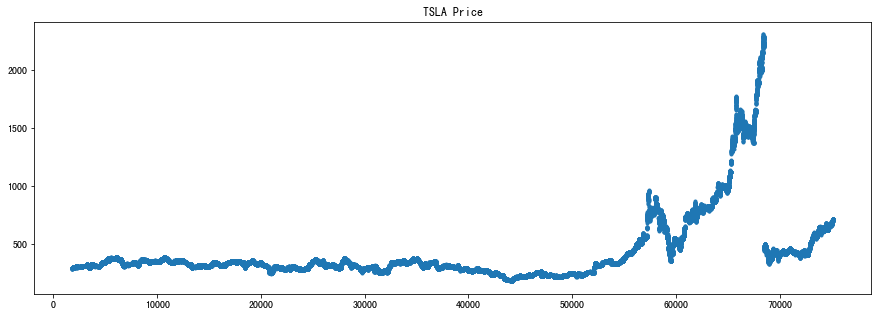

In [4]:
tsla = load_data(path = 'TSLA.csv')
# data visulization 1
tsla['price'].plot(figsize=(15,5), title='TSLA Price', style='.')
plt.show()

### Part 2 - Break the data and Formalising

In [5]:
def break_data(data, period):
    
    '''  
    divide the data by month

    Args:
    data - dataframe
    period - month

    Returns: dataframe     
    
    '''
        
        
    df = data[data.month == period]
    
    # print(df.groupby('day').price.count().head())
    
    day = df.day.unique()
    time =  df.time.unique()
    D = len(day)
    Obs = len(time)
    DAY = np.repeat(day,Obs)
    TIME = np.tile(time, D)
    
    tmp = pd.DataFrame({'day': DAY, 'time':TIME})
    final = df.merge(tmp, how = 'outer')
    final['Index'] = pd.to_datetime(final['day'].astype(str) + ' ' + final['time'].astype(str))
    final['qtr'] = final.Index.dt.to_period('Q')
    final['month'] = final.Index.dt.to_period('M')
    final['price_log'] = np.log(final['price'])
    final = final.sort_values(['Index'])
    final['price_log_pre'] = final['price_log'].shift(1)
    final['log_return'] = final['price_log'] - final['price_log_pre']
    
    
    return final
    

In [6]:
final = break_data(tsla, period = '2018Q2')
final.head()

,Index,day,time,qtr,month,price,price_log,price_log_pre,log_return
0,2018-04-02 09:30:00,2018-04-02,09:30:00,2018Q2,2018-04,254.60,5.539694,NaN,NaN
1,2018-04-02 09:35:00,2018-04-02,09:35:00,2018Q2,2018-04,252.75,5.532401,5.539694,-0.007293
2,2018-04-02 09:40:00,2018-04-02,09:40:00,2018Q2,2018-04,249.60,5.519860,5.532401,-0.012541
3,2018-04-02 09:45:00,2018-04-02,09:45:00,2018Q2,2018-04,248.80,5.516649,5.519860,-0.003210
4,2018-04-02 09:50:00,2018-04-02,09:50:00,2018Q2,2018-04,247.86,5.512864,5.516649,-0.003785


### Part 3 - DF statistics without jump

In [7]:
def DF_Statistics(data):
    
    data = data.dropna()
    n = data.shape[0]
    
    log_return = data['log_return']
    log_price_pre = data['price_log_pre']
    
    alpha = np.ones(n)  # alpha = 1
    beta = np.arange(n)  # beta*t = [0, 1, 2, ...]
    
    X = np.column_stack((log_price_pre, alpha))
    results = sm.OLS(log_return, X).fit()
    
    return results.tvalues[0]

In [8]:
DF_Statistics(final) 

-2.5516555887320047

### Part 4 - Jump Detection

In [9]:
def jump_detection(df, returns = 'log_return', alpha = 0.75):
    
    '''  
    Detect jumps

    Args:
    df - dataframe
    returns - 
    alpha

    Returns: 
    res - dataframe
    
    '''
        
        
    day = df.day.unique()
    time =  df.time.unique()
    D = len(day) # no. of days
    Obs = len(time) # no. of observation in each day
    
    log_return = df[returns]
    N = len(log_return)
    
    r = [np.nan] * N
    m = [np.nan] * N
    r_star = [np.nan] * N
    r_star_mul = [np.nan] * N
    BV = [np.nan] * N
    sigma = [np.nan] * N
    U = [np.nan] * N
    M = int(np.sqrt(Obs)) # Look at past M value
    i = math.ceil(M)
    
    while i <= N-1:
        r[i] = log_return[i]
        # print(r[i])
        m[i] = np.nanmedian(log_return[(i-M):i])
        # print(m[i])
        r_star[i] = r[i] - m[i]
        # print(r_star[i])
        r_star_mul[i] = abs(r_star[i-1]) * abs(r_star[i]) if r_star[i-1] != np.nan else np.nan
        # print(r_star_mul[i])
        BV[i] = np.nansum(r_star_mul[(i-M+2):(i+1)]) * M / (M-1) * np.pi / 2 if r_star_mul[i] != np.nan else np.nan
        # print(BV[i])
        sigma[i] = np.sqrt(BV[i] / M) if BV[i] != np.nan else np.nan
        # print(sigma[i])
        U[i] = r_star[i] / sigma[i] if sigma[i] != np.nan else np.nan
        # print(U[i])
        i = i+ 1
        # print(i)
        # print('---------')
    
    U_abs = list(map(abs, U))
    L = N
    CV = (2 * np.log(L))**(1/2) - 1/2 * (2*np.log(L))**(-1/2)*(np.log(4*np.pi) + np.log(np.log(L))) + (2 * np.log(L))**(-1/2) * (-np.log(-np.log(1-alpha/2)))
    jumps = (U_abs >= CV)
    res = df[['day', 'time']]
    res['jump'] = jumps
    
    res = df.merge(res, how = 'inner')
    res['jump'] = res['jump'].astype(int)
    res = res.dropna()
    
    
    return res 
    

In [10]:
jumps = jump_detection(final, returns = 'log_return', alpha = 0.75)

In [11]:
jumps.head()

,Index,day,time,qtr,month,price,price_log,price_log_pre,log_return,jump
1,2018-04-02 09:35:00,2018-04-02,09:35:00,2018Q2,2018-04,252.75,5.532401,5.539694,-0.007293,0
2,2018-04-02 09:40:00,2018-04-02,09:40:00,2018Q2,2018-04,249.60,5.519860,5.532401,-0.012541,0
3,2018-04-02 09:45:00,2018-04-02,09:45:00,2018Q2,2018-04,248.80,5.516649,5.519860,-0.003210,0
4,2018-04-02 09:50:00,2018-04-02,09:50:00,2018Q2,2018-04,247.86,5.512864,5.516649,-0.003785,0
5,2018-04-02 09:55:00,2018-04-02,09:55:00,2018Q2,2018-04,249.86,5.520901,5.512864,0.008037,0


### Part 5 - DF statistics with jump

In [12]:
def DF_Statistics_Jump(data):
    
    n = data.shape[0]
    
    log_return = data['log_return']
    log_price_pre = data['price_log_pre']
    jump = data['jump']
    
    alpha = np.ones(n)  # alpha = 1
    beta = np.arange(n)  # beta*t = [0, 1, 2, ...]
    
    X = np.column_stack((log_price_pre, jump, alpha))
    results = sm.OLS(log_return, X).fit()
    
    return results.tvalues[0]

In [13]:
DF_Statistics_Jump(data = jumps)

-2.5001733056153133

### Part 6 - DF Critical Value using Monte Carlo Simulation 

In [14]:
def generate_ar(n, phis, sigma=1):
    
    
    '''
        
    Generates an autoregressive series.

    The code follows: y_{t} = \phi_{1} y_{t-1} + \phi_{2} y_{t-2} + ... + \phi_{p} y_{t-p} + \epsilon_{t}

    Args:
        n: length of the series.
        phis: list of thetas, in the order \phi_{1}, \phi_{2}, ..., \phi_{p}.
        sigma: standard deviation of the innovations (optional).

    Returns:
        np.Array with the series.
    
    '''

    p = len(phis)
    adj_n = n + p  # We add q values because at the beginning we have no phis available.
    e_series = np.random.normal(0, sigma, size=adj_n)  # Generating a white noise.

    ar = [e_series[0]]  # We start the series with a random value
    for i in range(1, adj_n):
        visible_phis = phis[0:min(p, i)]  # At first, we only "see" some of the phis.
        visible_series = ar[i - min(p, i):i]  # The same happens to the white noise.
        reversed_phis = visible_phis[::-1]

        # Main equation.
        ar_t = e_series[i] + np.dot(reversed_phis, visible_series)

        ar.append(ar_t)

    ar = ar[p:]  # Dropping the first values that did not use all the phis.

    return ar



In [15]:
def dfcv_simulation(data, rep, jump_flag = True ):
    
    '''
    
    Generate critical value of DF distribution by monte carlo simulation
    
    
    '''
    
    np.random.seed(10)
    
    df = data
    start = df.day.min()
    end = df.day.max()
    repetitions = rep
    series_length = data.shape[0]
    percentiles = [2.5, 97.5]
    t_values = []
    
    for _ in range(repetitions):  
        y = generate_ar(series_length, [1])
        delta_y = np.diff(y)  # delta_y_{t} = y_{t+1} - y_{t}
        alpha = np.ones(series_length)  # alpha = 1
        
        if jump_flag == True:
            jumps_value = df['jump'].values
            regressors = np.column_stack((y, jumps_value, alpha))[:-1]
        else:
            regressors = np.column_stack((y, alpha))[:-1]
        
        results = sm.OLS(delta_y, regressors).fit()
        t_values.append(results.tvalues[0])

    #index = pd.MultiIndex.from_product([[start], [end]])
    #df_table = pd.DataFrame(columns=percentiles, index=index)
    
    res = []
    
    for percentile in percentiles:
        critical_t_value = np.percentile(t_values, percentile)
        res.append(critical_t_value)
        # df_table.loc[(start, end), percentile] = critical_t_value
        
    return res # df_table

In [16]:
# CV without jumps
dfcv_simulation(final, rep = 10, jump_flag = False )

[-2.483517128434954, 0.5670834013039572]

In [17]:
# CV with jumps
dfcv_simulation(jumps, rep = 10, jump_flag = True)

[-2.8452384776298536, -0.19542959472079327]

### Part 7 - Bubble detection

In [18]:
def bubble_check(path = 'TSLA.csv'):
    
    '''
    
    Buble check
    
    
    
    
    '''
    
    # 1. Load data
    data = load_data(path)
    
    # 2. Generate dataframe for outputs
    df_jump = pd.DataFrame()
    results = pd.DataFrame({'Start': pd.Series([], dtype='<M8[ns]'),
                            'End': pd.Series([], dtype='<M8[ns]'),
                            'Count': pd.Series([], dtype='int'),
                            'DF': pd.Series([], dtype='float'),
                            'Left_CV': pd.Series([], dtype='float'),
                            'Right_CV': pd.Series([], dtype='float'),
                            'DF_J': pd.Series([], dtype='float'),
                            'Left_CV_J': pd.Series([], dtype='float'),
                            'Right_CV_J': pd.Series([], dtype='float'),
                            'Jumps': pd.Series([], dtype='int')})
    
    
    # 3. brek data into month
    cohort = data.month.unique()
    
    
    for i in range(len(cohort)):

        df = break_data(data, period = cohort[i])
        
        count = df.shape[0]
        start = df.day.min()
        end = df.day.max()
        
        df_score = DF_Statistics(df)
        CV = dfcv_simulation(df, rep = 10, jump_flag = False )
        
        jumps = jump_detection(df, returns = 'log_return', alpha = 0.75)
        df_jump = df_jump.append(jumps)
        df_score_jump = DF_Statistics_Jump(data = jumps)
        CVJ = dfcv_simulation(jumps, rep = 10, jump_flag = True)
        no_jumps = jumps.jump.sum()
        
        results.loc[i, 'Start'] = start
        results.loc[i, 'End'] = end
        results.loc[i, 'Count'] = count
        results.loc[i, 'DF'] = round(df_score,3)
        results.loc[i, 'Left_CV'] = round(CV[0],3)
        results.loc[i, 'Right_CV'] = round(CV[1],3)
        
        results.loc[i, 'DF_J'] = round(df_score_jump,3)
        results.loc[i, 'Left_CV_J'] = round(CVJ[0],3)
        results.loc[i, 'Right_CV_J'] = round(CVJ[1],3)
        results.loc[i, 'Jumps'] = no_jumps
        results['bubble'] = (results.DF_J > results.Right_CV_J) & (results.DF <= results.Right_CV)
        #results.to_csv('bubble_test.csv')
        
    # Visulization
    plt.figure(figsize = (25,5))
    plt.plot('Index', 'price', data=df_jump)
    IS = df_jump[df_jump['jump'] == 1]
    plt.plot(IS["Index"], IS[["price"]], "ro", markersize=1)
    plt.savefig("jumps.png")

     
    return results, df_jump

In [23]:
df_jump.groupby('month').jump.mean()

month
2017-04    0.024499
2017-05    0.019633
2017-06    0.013241
2017-07    0.018448
2017-08    0.011564
2017-09    0.015833
2017-10    0.018423
2017-11    0.015524
2017-12    0.016000
2018-01    0.013872
2018-02    0.009852
2018-03    0.015743
2018-04    0.013973
2018-05    0.016695
2018-06    0.015078
2018-07    0.015700
2018-08    0.020601
2018-09    0.019333
2018-10    0.018172
2018-11    0.013358
2018-12    0.017473
2019-01    0.016285
2019-02    0.019081
2019-03    0.018697
2019-04    0.015682
2019-05    0.014968
2019-06    0.016466
2019-07    0.016213
2019-08    0.015571
2019-09    0.020899
2019-10    0.014868
2019-11    0.021154
2019-12    0.022961
2020-01    0.020833
2020-02    0.021378
2020-03    0.016166
2020-04    0.014475
2020-05    0.013300
2020-06    0.014968
2020-07    0.019574
2020-08    0.017502
2020-09    0.015719
2020-10    0.012090
2020-11    0.012579
2020-12    0.013833
Freq: M, Name: jump, dtype: float64

In [20]:
df_jump.jump.value_counts()

0    71949
1     1211
Name: jump, dtype: int64

month
2015-09       3
2015-10       7
2015-11      27
2015-12      19
2016-01      25
2016-02      73
2016-03      84
2016-04     102
2016-05     129
2016-06     128
2016-07     104
2016-08     124
2016-09     108
2016-10      83
2016-11     115
2016-12     167
2017-01     165
2017-02     179
2017-03     178
2017-04    1370
Freq: M, Name: price, dtype: int64
(75137, 6)
(73317, 6)


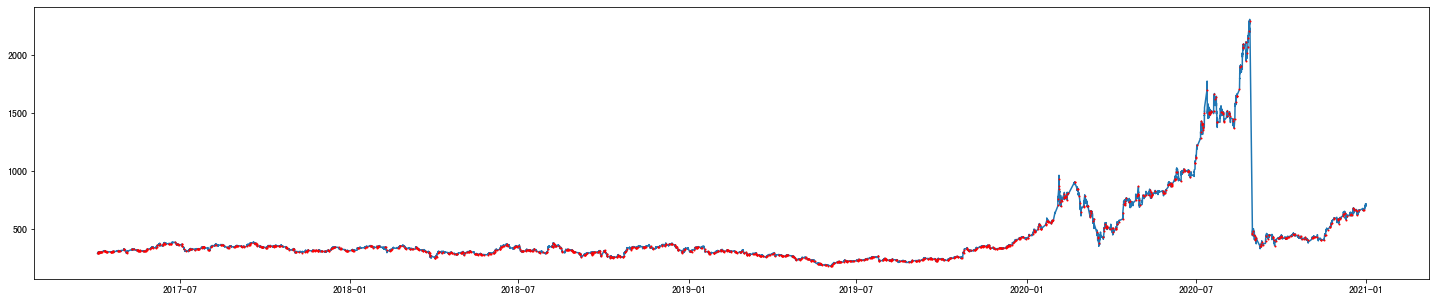

In [19]:
if __name__ == '__main__':
    results,df_jump = bubble_check()